## Часть 1
Напишите скрипт, который скачивает все данные с выборов губернатора СПб 2019г для всех избирательных участков. 

Входная точка [по ссылке](http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222). Затем нужно перейти на сайты территориальных избирательных комиссий. Результаты нужно сохранить в  `cvs`-файл, `sqlite` базе данных или `parquet`-файле. В итоге должна получиться таблица с полями:
- название ТИК (территориальная избирательная комиссия, некоторое объединение избирательных участков на определенной территории)
- номер УИК (избирательный участок)
- 14 стандартных полей из итогового протокола

Скрипт должен быть в отдельном `*.py` файле или в отдельном `jupyter`-ноутбуке. 

### Часть 2
Используя скаченные данные и `Pandas` (или `PySpark`) посчитайте:
- явку (%) по всем ТИК, результат отсортировать по убыванию
- выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат  (%, учитывать участки на которых проголосовало больше 100 человек)
- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна
- посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)
- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат
- визуализируйте отношение - явка на УИК $\rightarrow$ результат кандидата. 

In [221]:
import pandas as pd
import matplotlib.pyplot as plt

In [222]:
df = pd.read_csv('../data/election.csv', encoding='cp1251', index_col=False)

In [223]:
df.head()

,Тик,Уик,Количество избирателей,Полученные бюллетени,Выданные бюллетени в помещении,Выданные бюллетени вне помещения,Погашенные бюллетени,Число бюллетеней в переносных,Число бюллетеней в стационарных,Недействительные бюллетени,Действительные бюллетени,Утраченные бюллетени,Неучтенные бюллетени,Амосов,Беглов,Тихонова
0,1,1,1803,1200,587,11,602,11,587,23,575,0,0,110,345,120
1,1,2,1466,1100,433,14,653,14,430,19,425,0,0,53,326,46
2,1,3,2092,1600,576,22,1002,22,576,15,583,0,0,155,332,96
3,1,4,1056,1000,318,4,678,4,318,13,309,0,0,67,171,71
4,1,5,1827,1400,495,8,897,8,493,16,485,0,0,137,266,82


1. Явка (явку (%) по всем ТИК, результат отсортировать по убыванию)

In [224]:
df['Явка'] = round(100*(df['Выданные бюллетени в помещении']+df['Выданные бюллетени вне помещения'])/df['Количество избирателей'], 2)
df.sort_values('Явка', ascending=False)[['Тик', 'Количество избирателей', 'Уик', 'Явка']].head(10)

,Тик,Количество избирателей,Уик,Явка
1232,19,136,1355,100.0
881,13,603,1268,100.0
152,2,260,2376,100.0
1890,28,142,2338,100.0
1455,22,346,405,100.0
1453,22,668,403,100.0
1377,21,76,2343,100.0
150,2,220,2312,100.0
146,2,300,2308,100.0
1454,22,638,404,100.0


2. Выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат (%, учитывать участки на которых проголосовало больше 100 человек)

In [225]:
candidate = 'Беглов'
no_small_ones = df[(df['Число бюллетеней в переносных']+df['Число бюллетеней в стационарных'] > 100)]
result_of_candidate = 100 * no_small_ones[candidate]/(no_small_ones['Действительные бюллетени'] + no_small_ones['Недействительные бюллетени'])
m = result_of_candidate.max()
print('Результат', candidate, round(m,2), '%')
m = result_of_candidate.idxmax()
df.loc[m]

Результат Беглов 97.96 %


Тик                                   22.0
Уик                                  343.0
Количество избирателей              3537.0
Полученные бюллетени                4000.0
Выданные бюллетени в помещении      3523.0
Выданные бюллетени вне помещения       0.0
Погашенные бюллетени                 477.0
Число бюллетеней в переносных          0.0
Число бюллетеней в стационарных     3523.0
Недействительные бюллетени             0.0
Действительные бюллетени            3523.0
Утраченные бюллетени                   0.0
Неучтенные бюллетени                   0.0
Амосов                                23.0
Беглов                              3451.0
Тихонова                              49.0
Явка                                  99.6
Name: 1395, dtype: float64

3. Найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна

In [226]:
t = df.groupby('Тик')['Явка'].max() - df.groupby('Тик')['Явка'].min()
print('Разница:', round(t.max(), 2), '%')
print('Тик:', t.idxmax())

Разница: 82.04 %
Тик: 17


4. Посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)

In [231]:
print('В процентах')
df.groupby('Тик')['Явка'].var()

В процентах


Тик
1     193.182492
2     460.189470
3      74.141218
4     222.812922
5     136.607584
6      20.658776
7      71.114936
8     259.858288
9     118.920445
10     74.089792
11    239.452137
12     33.217540
13    393.513431
14     30.728267
15    416.084102
16    113.463276
17    329.331316
18    230.702131
19    204.701581
20    173.579607
21    310.193498
22    450.046257
23    586.702704
24    271.107408
25      9.175502
26    219.845443
27    206.334814
28    392.061516
29    244.380721
30    520.788431
Name: Явка, dtype: float64

5. Для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат

In [228]:
candidates = ['Амосов', 'Беглов', 'Тихонова']
for candidate in candidates:
    df[candidate + '%'] = round(100 * df[candidate]/(df['Действительные бюллетени'] + df['Недействительные бюллетени']))
    counts = df.groupby(candidate + '%').count()['Уик']
    print(counts)

Амосов%
0.0       1
1.0       6
2.0       6
3.0       2
4.0      13
5.0      18
6.0      25
7.0      35
8.0      48
9.0      68
10.0     89
11.0    100
12.0    117
13.0    130
14.0    131
15.0    160
16.0    153
17.0    152
18.0    126
19.0    102
20.0     89
21.0     82
22.0     77
23.0     44
24.0     56
25.0     40
26.0     45
27.0     26
28.0     26
29.0     17
30.0     15
31.0      5
32.0      6
33.0      4
34.0      1
35.0      3
36.0      2
42.0      1
Name: Уик, dtype: int64
Беглов%
30.0      1
32.0      1
33.0      2
38.0      3
39.0      3
40.0      3
41.0      5
42.0      3
43.0      3
44.0      9
45.0      8
46.0     10
47.0     21
48.0     14
49.0     24
50.0     27
51.0     37
52.0     37
53.0     44
54.0     36
55.0     52
56.0     62
57.0     68
58.0     77
59.0     79
60.0    122
61.0     93
62.0     92
63.0     97
64.0     90
       ... 
68.0     77
69.0     62
70.0     72
71.0     49
72.0     53
73.0     40
74.0     37
75.0     38
76.0     28
77.0     23
78.0     19


6. Визуализируйте отношение - явка на УИК → результат кандидата. 

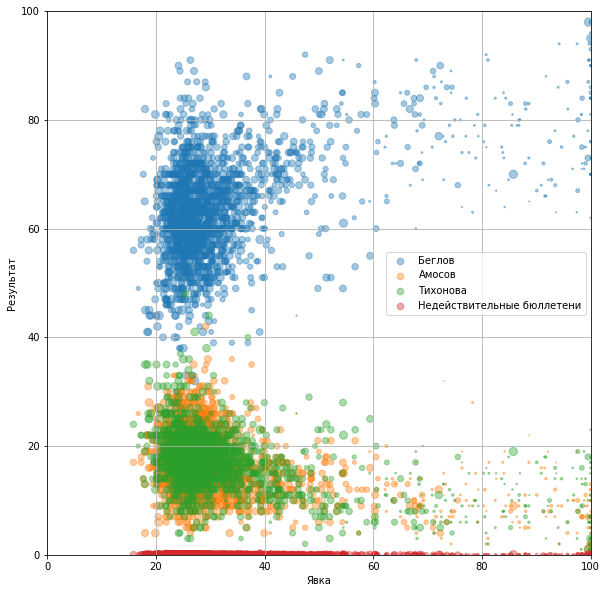

In [229]:
plt.figure(figsize=(10, 10))
plt.grid()
plt.axis('square')
plt.axis([0, 100, 0, 100])
plt.xlabel('Явка')
plt.ylabel('Результат')
plt.scatter(df['Явка'], df['Беглов%'], s=df['Количество избирателей']/50, alpha=0.4, label='Беглов')
plt.scatter(df['Явка'], df['Амосов%'], s=df['Количество избирателей']/50, alpha=0.4, label='Амосов')
plt.scatter(df['Явка'], df['Тихонова%'], s=df['Количество избирателей']/50, alpha=0.4, label='Тихонова')
plt.scatter(df['Явка'], df['Недействительные бюллетени']/(df['Недействительные бюллетени'] + df['Действительные бюллетени']), s=df['Количество избирателей']/50, alpha=0.4, label='Недействительные бюллетени')
plt.legend()